<a href="https://colab.research.google.com/github/aarunishsinha/SKFR-Python/blob/main/SKFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/BTP/SKFR_our

/content/drive/MyDrive/Colab Notebooks/BTP/SKFR_our


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as nmi, adjusted_rand_score as ari
from sklearn.cluster import KMeans
import random
import warnings
warnings.filterwarnings('ignore')

## Simple k-means (sklearn)

In [ ]:
def kmeans(X, k):
    km = KMeans(
        n_clusters=k, init='random',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0
    )
    cluster = km.fit_predict(X)
    centroids = km.cluster_centers_
    return centroids, cluster

## Utility functions

In [ ]:
def zscore(vec):
    m = np.mean(vec)
    s = np.std(vec)
    if s!=0:
        zs = (vec-m)/s
    else:
        zs = vec-m
    return zs
    
def scale(y, scale=True, center=True):
    x = y.copy()
    if center:
        x -= np.mean(x)
    if scale and center:
        x /= np.std(x)
    elif scale:
        x /= np.sqrt(x.pow(2).sum().div(x.count()-1))
    return x

## SKFR-1

In [ ]:
 def skfr1(X,Class,classes,sparsity):
    features = X.shape[0]
    cases = X.shape[1]
    center = np.zeros((features,classes))
    members = np.zeros(classes)
    criteria = np.zeros(features)
    distance = np.zeros((classes,cases))
    wholevec = np.arange(0,features)

    for i in range(features):
        X[i,:] = zscore(X[i,:])

    switched = True
    iternum = 1
    importantvec = np.zeros(sparsity)
    loss_list = []
    while switched:
        center = np.zeros((features,classes))
        members = np.zeros(classes)
        for j in range(cases):
            i = Class[j]
            center[:,i] = center[:,i] + X[:,j]
            members[i] = members[i] + 1
        for j in range(classes):
            if members[j]>0:
                center[:,j] = center[:,j]/members[j]
        for i in range(features):
            criteria[i] = 0
            for j in range(classes):
                criteria[i] = criteria[i] + members[j]*((center[i][j])**2)
        index = [i for i in range(len(criteria))]
        sorted_criteria = sorted(zip(criteria,index))
        J = [x[1] for x in sorted_criteria]
        J = np.array(J)
        J = J[:features-sparsity]
        importantvec = list(set(wholevec)-set(J))
        for i in range(len(J)):
            center[J[i]] = np.zeros(classes)
        for i in range(classes):
            for j in range(cases):
                distance[i][j] = np.sqrt(np.sum((center[:,i]-X[:,j])**2))
        switched = False
        for i in range(cases):
            j = np.argmin(distance[:,i])
            if j!=Class[i]:
                switched =True
                Class[i] = j
        WSStemp = np.zeros(classes)
        for k in range(classes):
            tempIndex = np.where(Class==k)[0]
            tempX = np.zeros((features,len(tempIndex)))
            for j in range(len(tempIndex)):
                tempX[:,j] = X[:,tempIndex[j]]
            WSStemp[k] = np.mean(((tempX.T-center[:,k]).T)**2)
        loss = np.sum(WSStemp)
        loss_list.append(loss)
        # print('Iteration : {}, Loss : {}'.format(iternum, loss))
        iternum += 1
    return center, Class, loss_list

## SKFR-2

In [ ]:
def skfr2(X,Class,classes,sparsity):
    features = X.shape[0]
    cases = X.shape[1]
    center = np.zeros((features,classes))
    members = np.zeros(classes)
    criteria = np.zeros(features)
    distance = np.zeros((classes,cases))
    importantvec = np.zeros((classes, sparsity))
    wholevec = np.arange(0,features)

    for i in range(features):
        X[i,:] = zscore(X[i,:])
    
    switched = True
    loss_list = []
    while switched:
        center = np.zeros((features,classes))
        members = np.zeros(classes)
        for j in range(cases):
            i = Class[j]
            center[:,i] = center[:,i] + X[:,j]
            members[i] = members[i] + 1
        for i in range(classes):
            if members[i]>0:
                center[:,i] = center[:,i]/members[i]
                criteria = (center[:,i]**2)*members[i]
                index = [i for i in range(len(criteria))]
                sorted_criteria = sorted(zip(criteria,index))
                J = [x[1] for x in sorted_criteria]
                J = np.array(J)
                J = J[:features-sparsity]
                for j in J:
                    center[j,i] = 0
                importantvec = np.array(list(set(wholevec)-set(J)))
        switched = False
        for i in range(classes):
            for j in range(cases):
                distance[i][j] = np.sqrt(np.sum((center[:,i]-X[:,j])**2))
        for i in range(cases):
            j = np.argmin(distance[:,i])
            if j!=Class[i]:
                switched =True
                Class[i] = j
        WSStemp = np.zeros(classes)
        for k in range(classes):
            tempIndex = np.where(Class==k)[0]
            tempX = np.zeros((features,len(tempIndex)))
            for j in range(len(tempIndex)):
                tempX[:,j] = X[:,tempIndex[j]]
            WSStemp[k] = np.mean(((tempX.T-center[:,k]).T)**2)
        loss = np.sum(WSStemp)
        loss_list.append(loss)
        # print('Iteration : {}, Loss : {}'.format(iternum, loss))
        # iternum += 1
    return center, Class, loss_list

## Plotting Functions

In [ ]:
def plot_data(X):
    plt.scatter(
    X[:, 0], X[:, 1],
    c='white', marker='o',
    edgecolor='black', s=50
    )
    plt.show()

def plot_clusters(X,centroids,cluster):
    sns.scatterplot(X[:,0], X[:, 1], hue=cluster)
    sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
    plt.xlabel('feature1')
    plt.ylabel('feature2')
    plt.show()

def plot_loss(loss_list):
    epochs = [i for i in range(len(loss_list))]
    plt.plot(epochs,loss_list)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

## Process Data

In [ ]:
def processed_data(X):
    features = X.shape[0]
    cases = X.shape[1]
    m = features//3
    n = 2*m
    r = cases//3 + 1
    s = 2*(r - 1)
    for i in range(m):
        for j in range(r-1,s):
            X[i][j] += 1.0

    for i in range(m):
        for j in range(s,cases):
            X[i][j] += 2.0
    return X

##Comparision

[[ 0.86915498  0.79231691  0.86031645  0.73693356  0.94824911  0.81810074
   0.90476898  0.78805831  0.76887071  0.78941813  0.72549827  0.78969282
   0.71901445  0.79135944  0.76123064  0.7354381   0.84245875  0.76046867
   0.81372807  0.77641417  0.76108524  0.78169136  0.83349948  0.82485984
   0.75179096  0.77014105  0.78704558  0.70492177  0.70356701  0.71832532
   0.7569728   0.79728976  0.80315141  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.       

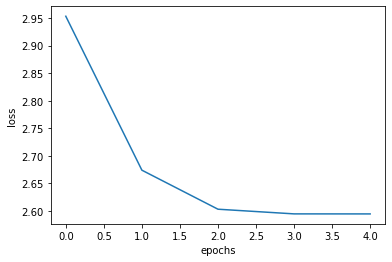

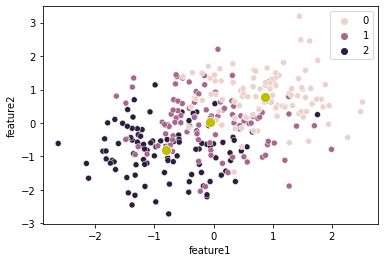

In [ ]:
X = pd.read_csv("X.csv").values
Class = pd.read_csv("class.csv").values.reshape(-1,)
for i in range(len(Class)):
    Class[i]-=1
features = 100
cases = 300
classes = 3
sparsity = 33
X = processed_data(X)

centroids, cluster, loss_list = skfr1(X,Class,3,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)

[[ 0.86915498  0.79231691  0.86031645  0.73693356  0.94824911  0.81810074
   0.90476898  0.78805831  0.76887071  0.78941813  0.72549827  0.78969282
   0.71901445  0.79135944  0.76123064  0.7354381   0.84245875  0.76046867
   0.81372807  0.77641417  0.76108524  0.78169136  0.83349948  0.82485984
   0.75179096  0.77014105  0.78704558  0.70492177  0.70356701  0.71832532
   0.7569728   0.79728976  0.80315141  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.       

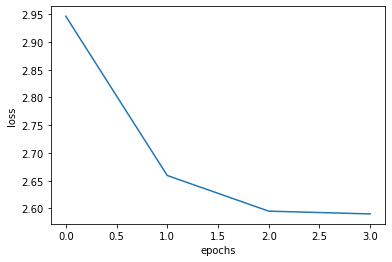

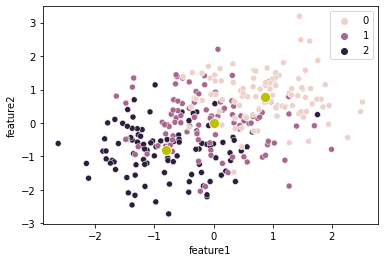

In [ ]:
X = pd.read_csv("X.csv").values
Class = pd.read_csv("class.csv").values.reshape(-1,)
for i in range(len(Class)):
    Class[i]-=1
features = 100
cases = 300
classes = 3
sparsity = 33
X = processed_data(X)

centroids, cluster, loss_list = skfr2(X,Class,3,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)

##Random Data

[[  7.903889     8.04727507]
 [ -4.2646143    4.27230943]
 [ -0.21057812   0.1919213 ]
 [-11.9334828   12.13796893]]


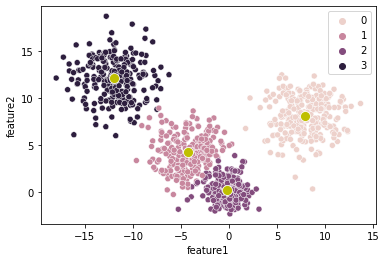

In [ ]:
features = 2
cases = 1000
k = 4
sparsity = 2
X_random = np.random.normal(0,1,size=(features,cases//k))
j = 4
p = 1
for i in range(k-1):
    tmp = np.random.normal(j,2,size=(features,cases//k))
    if i%2==0:
        tmp[0] = -1*tmp[0]
    j+=4
    X_random = np.concatenate((X_random,tmp),axis=1)

X_random = processed_data(X_random)

Class = np.array(random.choices([i for i in range(k)],k=cases))

centroids, cluster = kmeans(X_random.T, k)
print(centroids)
plot_clusters(X_random.T,centroids,cluster)

[[ 0.24094121 -1.24792161]
 [ 1.34234901  0.42659706]
 [-1.35468925  1.23360587]
 [-0.27835293 -0.30930434]]


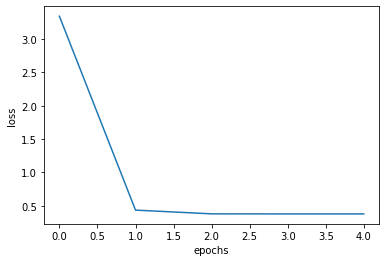

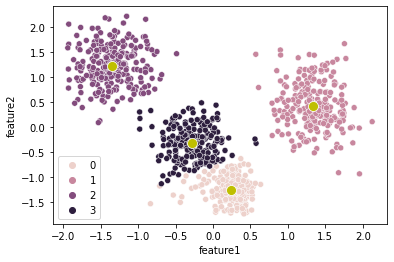

In [ ]:
features = 2
cases = 1000
k = 4
sparsity = 2
X_random = np.random.normal(0,1,size=(features,cases//k))
j = 4
p = 1
for i in range(k-1):
    tmp = np.random.normal(j,2,size=(features,cases//k))
    if i%2==0:
        tmp[0] = -1*tmp[0]
    j+=4
    X_random = np.concatenate((X_random,tmp),axis=1)

X_random = processed_data(X_random)

Class = np.array(random.choices([i for i in range(k)],k=cases))

centroids, cluster, loss_list = skfr1(X_random,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X_random.T,centroids.T,cluster)

[[ 0.21503998 -1.22921992]
 [-1.36698825  1.23834813]
 [ 1.34222499  0.43051456]
 [-0.24665717 -0.2826052 ]]


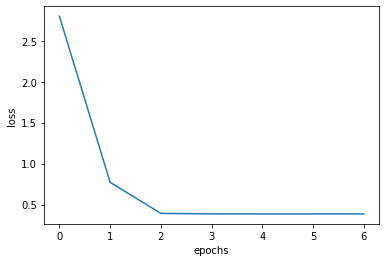

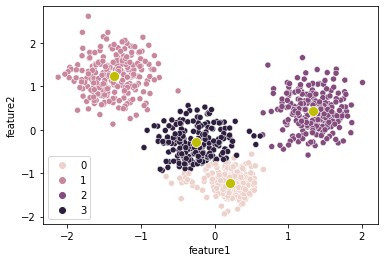

In [ ]:
features = 2
cases = 1000
k = 4
sparsity = 2
X_random = np.random.normal(0,1,size=(features,cases//k))
j = 4
p = 1
for i in range(k-1):
    tmp = np.random.normal(j,2,size=(features,cases//k))
    if i%2==0:
        tmp[0] = -1*tmp[0]
    j+=4
    X_random = np.concatenate((X_random,tmp),axis=1)

X_random = processed_data(X_random)

Class = np.array(random.choices([i for i in range(k)],k=cases))

centroids, cluster, loss_list = skfr2(X_random,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X_random.T,centroids.T,cluster)

##Mice Dataset

In [ ]:
data = pd.read_csv('Data_Cortex_Nuclear.csv')

data = data.dropna(axis=0,how='any')
Y = np.array(data['class'].astype('category').cat.codes)
data = data.select_dtypes(include='number')

data.head(2)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,RAPTOR_N,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
75,0.649781,0.828696,0.405862,2.921435,5.167979,0.207174,0.176640,3.728084,0.239283,1.666579,0.969466,0.321260,0.406562,0.255293,1.056343,1.099300,1.925284,2.231671,0.426859,0.873228,0.512773,0.343220,0.167629,1.852756,3.366492,1.503675,0.246019,0.305424,0.851006,0.165179,0.441557,2.578215,0.340857,0.487664,0.401050,0.781365,0.534033,0.431846,0.618023,0.361417,0.321960,0.427297,0.252056,0.242086,1.061181,0.163758,1.862368,0.321175,0.541041,2.159547,0.134639,0.158178,0.196124,0.132001,0.161120,0.210988,0.210379,0.128145,0.292461,0.152597,0.527242,0.348062,1.687551,2.436587,0.168172,1.139154,0.987774,0.239752,0.139052,0.112926,0.132001,0.129363,0.486912,0.125152,0.146865,0.143517,1.627181
76,0.616481,0.841974,0.388584,2.862575,5.194163,0.223433,0.167725,3.648240,0.221030,1.565150,0.991845,0.342918,0.396910,0.270815,1.032790,1.078712,1.893047,2.330987,0.409185,0.789013,0.511502,0.344807,0.166695,1.852532,3.431159,1.471674,0.242060,0.300172,0.833648,0.162661,0.437253,2.538026,0.337682,0.472618,0.402318,0.786524,0.533219,0.429871,0.603176,0.360258,0.296052,0.425837,0.252017,0.242120,1.063985,0.169981,1.692204,0.320473,0.539226,2.167098,0.136273,0.161579,0.193348,0.139008,0.161529,0.210798,0.193398,0.134583,0.291489,0.151884,0.519787,0.365119,1.662872,2.354728,0.174704,1.227851,0.981655,0.249031,0.133787,0.121607,0.139008,0.143084,0.467833,0.112857,0.161132,0.145719,1.562096


[[ 4.01492286e-01  3.78106955e-01 -2.25210561e-01 -7.24785154e-02
   3.07995928e-03 -9.58375965e-01 -9.39735110e-01 -6.35528494e-01
  -3.78505229e-01 -8.17747091e-02  5.20948126e-01 -8.57570646e-01
  -1.85046864e-01 -9.02236425e-01 -7.99611602e-02 -3.59119148e-01
  -1.68032024e-01  2.49677639e-01 -4.54983909e-01 -3.97787042e-01
   1.97723587e-01 -6.84323912e-01 -8.44567575e-01  3.13038925e-02
   1.61367092e-01  2.92745256e-01 -6.52802726e-01 -5.11601276e-01
  -1.92812147e-01 -9.02392091e-01 -1.39482281e-01 -4.44039756e-02
  -4.98043855e-01 -7.24118599e-01 -6.87042408e-01 -8.30444480e-01
  -8.63722036e-01 -3.79054757e-01 -7.74877918e-01 -5.43261315e-02
  -8.25010285e-01 -4.24711316e-01 -5.12412051e-01  6.35306562e-01
   3.54156007e-01  3.72292400e-01  4.30875505e-02  2.72210251e-01
   7.12816477e-01  1.23557280e-01  3.22421786e-02  3.02751566e-02
   4.37527876e-01 -3.07186522e-01 -1.56406553e-01  5.33438250e-02
   1.38814288e-01  2.33096126e-01  9.24988664e-01  7.08826461e-01
  -1.07691

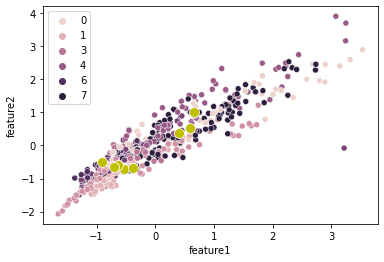

NMI:  0.31360141323539986
ARI:  0.1623282079582171


In [ ]:
X = data.values.T

features = X.shape[0]
for i in range(features):
    X[i,:] = zscore(X[i,:])

centroids, cluster = kmeans(X.T, k=8)
print(centroids)
plot_clusters(X.T,centroids,cluster)

print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

[[ 0.78492223  0.7509791   0.40681853  0.2364707   0.2638742   0.45212197
   0.4416337   0.54267722  0.42477408  0.          0.71147786  0.44312453
   0.75758925  0.40878664  0.12217128  0.14381016  0.18917948  0.
   0.88742988  0.10342642  0.81654533  0.41287174  0.51062852  0.26148242
   0.2102509   0.          0.          0.          0.          0.
   0.50307328  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.87250451  1.09801857  1.13299557  1.31595542  1.36976923  0.3220945
   0.43225586  0.35308382  0.88325436  0.       

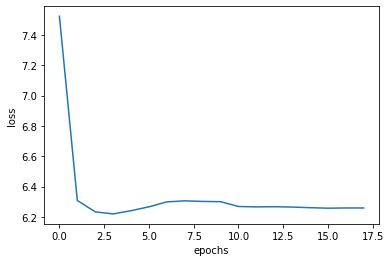

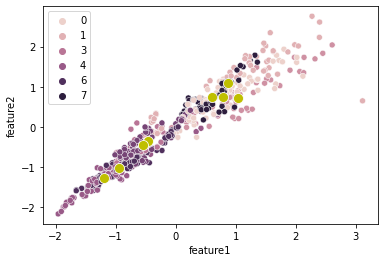

NMI:  0.43541864751792964
ARI:  0.2585368175691125


In [ ]:
X = data.values.T

features = X.shape[0]
cases = X.shape[1]
k = 8
sparsity = 24

X = processed_data(X)
Class = np.array(random.choices([i for i in range(k)],k=cases))

centroids, cluster, loss_list = skfr1(X,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)

print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

[[ 0.64768934  0.52414688  0.          0.          0.          0.
   0.          0.          0.          0.          0.63133864  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.74660751  0.          0.          0.
   0.          0.95667463  0.63215262  0.          0.          0.
   0.62341375  0.         -0.74519273 -0.47383524 -0.65793732  0.
   0.          0.          0.          0.          0.          0.
   0.83289831  0.          0.          0.60318785  0.55954717  0.
   0.53249743  0.          0.          0.          0.         -0.99558386
  -0.63786205  0.          0.          0.          0.          0.
  -0.78771909  0.         -0.55686267  0.         -1.08175216 -0.48691327
   0.5869567  -0.6306581   0.          0.         -0.99558386  0.
   0.          0.          0.          0.          0.93682305]
 [-1.23468162 -1.24810284 -1.24007536 -1.24702599 -1.19143656 -1.19453734
  -1.23801971  0.         -1.27142214 -1.25657099 -1.22

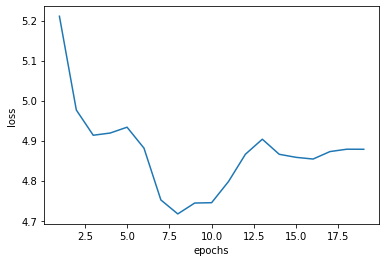

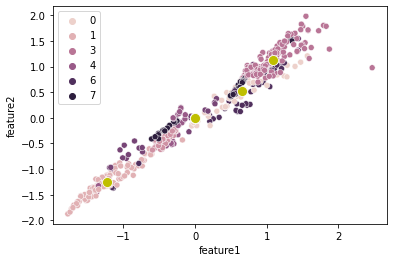

NMI:  0.5958341357503565
ARI:  0.38788662817676933


In [ ]:
X = data.values.T

features = X.shape[0]
cases = X.shape[1]
k = 8
sparsity = 24

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr2(X,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)
print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

## Thyroid Dataset

[[-4.20277255e-03  0.00000000e+00  0.00000000e+00 -5.03880269e-04
   1.17793156e-03  3.48766848e-03  4.53586821e-17  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.19557740e+00  0.00000000e+00  0.00000000e+00  1.21132817e+00
   1.21276468e+00  1.19029143e+00  1.21498116e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.19137462e+00  0.00000000e+00  0.00000000e+00 -1.21082429e+00
  -1.21394261e+00 -1.19377910e+00 -1.21498116e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.0

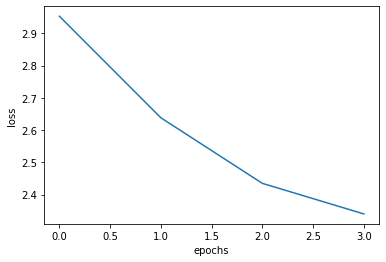

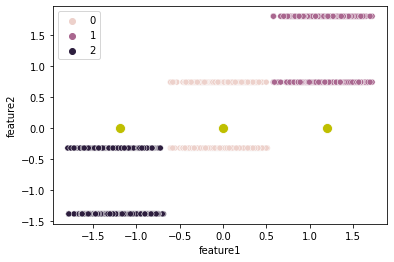

NMI:  0.000288877493193194
ARI:  -1.8993142002988062e-05


In [ ]:
columns = np.loadtxt('thyroid.dat', max_rows=1,dtype='str', delimiter=', ')
data = np.loadtxt('thyroid.dat', skiprows=1, dtype=np.float64, delimiter=', ')
data = pd.DataFrame(data,columns=columns)
data = data.dropna(axis=0,how='any')
Y = data['Class'] - 1
X_ = data.select_dtypes(include='number')

X = X_.values.T

features = X.shape[0]
cases = X.shape[1]
k = 3
sparsity = 5

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr1(X,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)
print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

[[ 1.19557740e+00  1.06281339e+00  1.13603498e+00  1.21132817e+00
   1.21276468e+00  1.19029143e+00  1.21498116e+00  1.53526757e-02
  -2.37708132e-02 -2.41298413e-02  3.29343624e-03  7.70844426e-02
  -2.15686277e-02  7.04103147e-03 -1.17859315e-02  2.44754333e-02
   5.64140086e-03  4.37928886e-03  1.34693342e-02 -7.04153326e-02
   6.19225508e-02  0.00000000e+00]
 [-1.19137462e+00 -1.07460932e+00 -1.12881209e+00 -1.21082429e+00
  -1.21394261e+00 -1.19377910e+00 -1.21498116e+00 -9.44780045e-03
  -1.08049151e-02 -1.73959321e-02 -2.96409261e-02 -6.46514680e-02
  -7.70308131e-03 -6.16090253e-03  2.35718630e-02 -1.61022587e-02
  -1.98955020e-03  5.81522396e-02 -2.55877420e-02  4.03277889e-02
  -5.98847223e-02  0.00000000e+00]
 [-4.20277255e-03  1.17959310e-02 -7.22288999e-03 -5.03880269e-04
   1.17793156e-03  3.48766848e-03  0.00000000e+00 -5.90487528e-03
   3.45757283e-02  4.15257733e-02  2.63474899e-02 -1.24329746e-02
   2.92717090e-02 -8.80128934e-04 -1.17859315e-02 -8.37317455e-03
  -3.6

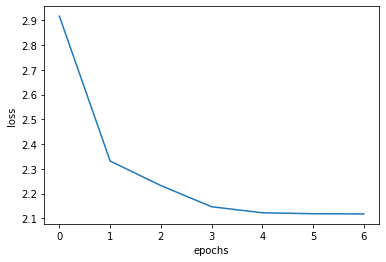

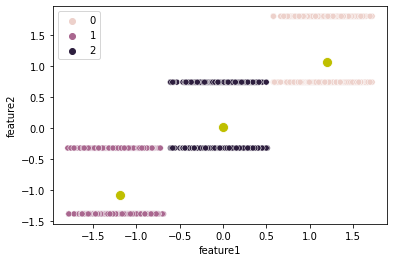

NMI:  0.000288877493193194
ARI:  -1.8993142002988062e-05


In [ ]:
columns = np.loadtxt('thyroid.dat', max_rows=1,dtype='str', delimiter=', ')
data = np.loadtxt('thyroid.dat', skiprows=1, dtype=np.float64, delimiter=', ')
data = pd.DataFrame(data,columns=columns)
data = data.dropna(axis=0,how='any')
Y = data['Class'] - 1
X_ = data.select_dtypes(include='number')

X = X_.values.T

features = X.shape[0]
cases = X.shape[1]
k = 3
sparsity = 21

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr2(X,Class,k,sparsity)
print(centroids.T)
plot_loss(loss_list)
plot_clusters(X.T,centroids.T,cluster)
print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

##WARP10P

In [ ]:
X_ = pd.read_csv('ar10px.csv', header=None).values
Y = (pd.read_csv('ar10py.csv', header=None).values-1).reshape(-1,)

X = X_.T

features = X.shape[0]
cases = X.shape[1]
k = 10
sparsity = 2000

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr1(X,Class,k,sparsity)

print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

NMI:  0.21674492542136048
ARI:  0.025504192944764012


In [ ]:
X_ = pd.read_csv('ar10px.csv', header=None).values
Y = (pd.read_csv('ar10py.csv', header=None).values-1).reshape(-1,)

X = X_.T

features = X.shape[0]
cases = X.shape[1]
k = 10
sparsity = 2000

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr2(X,Class,k,sparsity)

print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

NMI:  0.15841710849729582
ARI:  0.005349139800491545


##Iris Dataset

In [ ]:
data = np.loadtxt('iris.dat', skiprows=9,usecols=(0,1,2,3), delimiter=', ')
columns = ['SepalLength','SepalWidth', 'PetalLength', 'PetalWidth']
X_ = pd.DataFrame(data,columns=columns)

data = np.loadtxt('iris.dat', skiprows=9,usecols=(4),dtype='str', delimiter=', ')
data = pd.DataFrame(data,columns=['Class'])

Y = np.array(data['Class'].astype('category').cat.codes)

X = X_.values.T
print(X.shape,Y.shape)

features = X.shape[0]
cases = X.shape[1]
k = 3
sparsity = 2

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr1(X,Class,k,sparsity)

print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

(4, 150) (150,)
NMI:  0.864185506820222
ARI:  0.8856970310281228


In [ ]:
data = np.loadtxt('iris.dat', skiprows=9,usecols=(0,1,2,3), delimiter=', ')
columns = ['SepalLength','SepalWidth', 'PetalLength', 'PetalWidth']
X_ = pd.DataFrame(data,columns=columns)

data = np.loadtxt('iris.dat', skiprows=9,usecols=(4),dtype='str', delimiter=', ')
data = pd.DataFrame(data,columns=['Class'])

Y = np.array(data['Class'].astype('category').cat.codes)

X = X_.values.T
print(X.shape,Y.shape)

features = X.shape[0]
cases = X.shape[1]
k = 3
sparsity = 4

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr2(X,Class,k,sparsity)

print('NMI: ', nmi(Y,cluster))
print('ARI: ', ari(Y,cluster))

(4, 150) (150,)
NMI:  0.7356125873882283
ARI:  0.7278450047294432


##Zoo Dataset

In [ ]:
data = np.loadtxt('zoo.dat', skiprows=21, delimiter=',')
columns = ['Hair', 'Feathers', 'Eggs', 'Milk', 'Airborne', 'Aquatic', 'Predator', 'Toothed', 'Backbone', 'Breathes', 'Venomous', 'Fins', 'Legs', 'Tail', 'Domestic', 'Catsize', 'Class']
data = pd.DataFrame(data,columns=columns)
X_ = data.select_dtypes(include='number')

Y = data['Class']-1

X = X_.values.T
# print(X.shape,Y.shape)

features = X.shape[0]
cases = X.shape[1]
k = 7
sparsity = 11

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr1(X,Class,k,sparsity)

print('NMI: ', nmi(Y,cluster), end=" ")
print('ARI: ', ari(Y,cluster))


NMI:  0.5607049730090577 ARI:  0.41521690627049007


In [ ]:
data = np.loadtxt('zoo.dat', skiprows=21, delimiter=',')
columns = ['Hair', 'Feathers', 'Eggs', 'Milk', 'Airborne', 'Aquatic', 'Predator', 'Toothed', 'Backbone', 'Breathes', 'Venomous', 'Fins', 'Legs', 'Tail', 'Domestic', 'Catsize', 'Class']
data = pd.DataFrame(data,columns=columns)
X_ = data.select_dtypes(include='number')

Y = data['Class']-1

X = X_.values.T
# print(X.shape,Y.shape)

features = X.shape[0]
cases = X.shape[1]
k = 7
sparsity = 11

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr2(X,Class,k,sparsity)

print('NMI: ', nmi(Y,cluster), end=" ")
print('ARI: ', ari(Y,cluster))

NMI:  0.6560698482191862 ARI:  0.40962888681226167


##Wine Dataset

In [ ]:
data = np.loadtxt('wine.dat', skiprows=18, delimiter=',')
columns = ['Alcohol', 'MalicAcid', 'Ash', 'AlcalinityOfAsh', 'Magnesium', 'TotalPhenols', 'flavanoids', 'NonflavanoidsPhenols', 'Proanthocyanins', 'ColorIntensity', 'Hue', 'OD280/OD315', 'Proline', 'Class']
data = pd.DataFrame(data,columns=columns)
X_ = data.select_dtypes(include='number')

Y = data['Class']-1

X = X_.values.T
print(X.shape,Y.shape)

features = X.shape[0]
cases = X.shape[1]
k = 3
sparsity = 10

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr1(X,Class,k,sparsity)

print('NMI: ', nmi(Y,cluster), end=" ")
print('ARI: ', ari(Y,cluster))


(14, 178) (178,)
NMI:  0.8693505970676253 ARI:  0.8782789330000148


In [ ]:
data = np.loadtxt('wine.dat', skiprows=18, delimiter=',')
columns = ['Alcohol', 'MalicAcid', 'Ash', 'AlcalinityOfAsh', 'Magnesium', 'TotalPhenols', 'flavanoids', 'NonflavanoidsPhenols', 'Proanthocyanins', 'ColorIntensity', 'Hue', 'OD280/OD315', 'Proline', 'Class']
data = pd.DataFrame(data,columns=columns)
X_ = data.select_dtypes(include='number')

Y = data['Class']-1

X = X_.values.T
print(X.shape,Y.shape)

features = X.shape[0]
cases = X.shape[1]
k = 3
sparsity = 10

X = processed_data(X)

Class = np.array(random.choices([i for i in range(k)],k=cases))
centroids, cluster, loss_list = skfr2(X,Class,k,sparsity)

print('NMI: ', nmi(Y,cluster), end=" ")
print('ARI: ', ari(Y,cluster))

(14, 178) (178,)
NMI:  0.8693505970676253 ARI:  0.8782789330000148
